In [1]:
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from collections import defaultdict

In [2]:
plt.style.use('seaborn')

In [3]:
base_folder = '../domain_adaptation_results/training_logs/'
measures_names = ['average_preds',
                  'ma_example_f1', 'ma_example_p', 'ma_example_r',
                  'micro_f1', 'micro_p', 'micro_r',
                  'ma_types_f1', 'ma_types_p', 'ma_types_r',
                  'total_types_pred'
                  ]
header_regex = '[A-z ]+[0-9 ]+:[0-9 ]+:[0-9 ]+ [0-9]+'

rainbow_colors_lines = ['#ff0000', '#ffa500', '#00ff00', '#008000', '#0000ff', '#4b0082', '#ee82ee', '#000000']
rainbow_colors_errors = ['#aa0000', '#aaa500', '#aaf000', '#003000', '#0000aa', '#4b0022', '#9982ee', '#ffffff']

In [4]:
def get_files(s, t, sample_size):
    files = os.listdir(base_folder)
    selected_files = [f for f in files if s in f and t in f and str(sample_size) + '_' in f]
    selected_files.extend([f for f in files if 'from_scratch_{}_k{}_{}.txt'.format(t, sample_size, sample_size) in f])
    selected_files.extend([f for f in files if 'from_scratch_{}_{}_{}.txt'.format(t, sample_size, sample_size) in f])
    return [base_folder + s for s in selected_files]            

In [5]:
def get_measures(file):
    with open(file, 'r') as inp:
        lines = [l.replace('\n', '') for l in inp.readlines()]
    all_measures = {n:[] for n in measures_names}
    measures = {n: [] for n in measures_names}
    matched = False
    for l in lines:
        if re.match(header_regex, l):
            for k, v in all_measures.items():
                if measures[k]:
                    v.append(measures[k])
            measures = {n: [] for n in measures_names}
            matched = True
        elif l == '':
            pass
        else:
            meas = l.split('\t')
            for i, k in enumerate(measures_names):
                measures[k].append(meas[i])
    for k, v in all_measures.items():
        if measures[k]:
            v.append(measures[k])
    return all_measures

In [6]:
def get_epoch_metrics(file_name):
    measures = get_measures(file_name)
    
    epoch_metrics = {k : defaultdict(list) for k in measures_names}

    for k, v in measures.items():
        for sublist in v:
            for i, elem in enumerate(sublist):
                epoch_metrics[k][i].append(float(elem))
    
    epoch_metrics_mean_std = {k: {e: {'mean': np.mean(values), 
                                      'std': np.std(values) if not np.isnan(np.std(values)) else 0} 
                                  for e, values in v.items()} 
                              for k, v in epoch_metrics.items()}
    return epoch_metrics_mean_std

In [7]:
def add_error_bar_to_ax(key, epoch_dict, ax, label, line_color, e_color, err = True):
    x = [i * 10 for i in epoch_dict[key]]
    y = [epoch_dict[key][i]['mean'] for i in epoch_dict[key]]
    yerr = [epoch_dict[key][i]['std'] for i in epoch_dict[key]]
    ax.set_title(key)
    if err:
        ax.errorbar(x=x, y=y, yerr=yerr, label = label, c = line_color, ecolor=e_color)
    else:
        ax.errorbar(x=x, y=y, label = label, c = line_color)
    

In [8]:
def add_errors_to_all_subplots(epoch_dict, label, line_color, e_color, err):
    for i, name in enumerate(measures_names[1 : -1]):
        row = int(np.floor(i/3))
        col = i % 3
        add_error_bar_to_ax(name, epoch_dict, axs[row][col], label, line_color, e_color, err)

# DA from Figer to BBN

In [10]:
source = 'figer'
target = 'bbn'
sample_sizes = [20, 50, 100, 200, 500, 1000, 2000, 'all']

In [14]:
epoch_dicts = {}
for size in sample_sizes[2:3]:
    files = get_files(source, target, size)
    for file in files:
#         if 'from_scratch' in file:
        try:
            epoch_dicts[file.replace(base_folder, '')] = get_epoch_metrics(file)
        except:
            pass

In [15]:
files

['../domain_adaptation_results/training_logs/INCR_AD_s_figer_t_bbn_k100_100.txt',
 '../domain_adaptation_results/training_logs/L2AWE_s_figer_t_bbn_k100_100.txt',
 '../domain_adaptation_results/training_logs/FTAD_s_figer_t_bbn_k100_100.txt',
 '../domain_adaptation_results/training_logs/from_scratch_bbn_k100_100.txt']

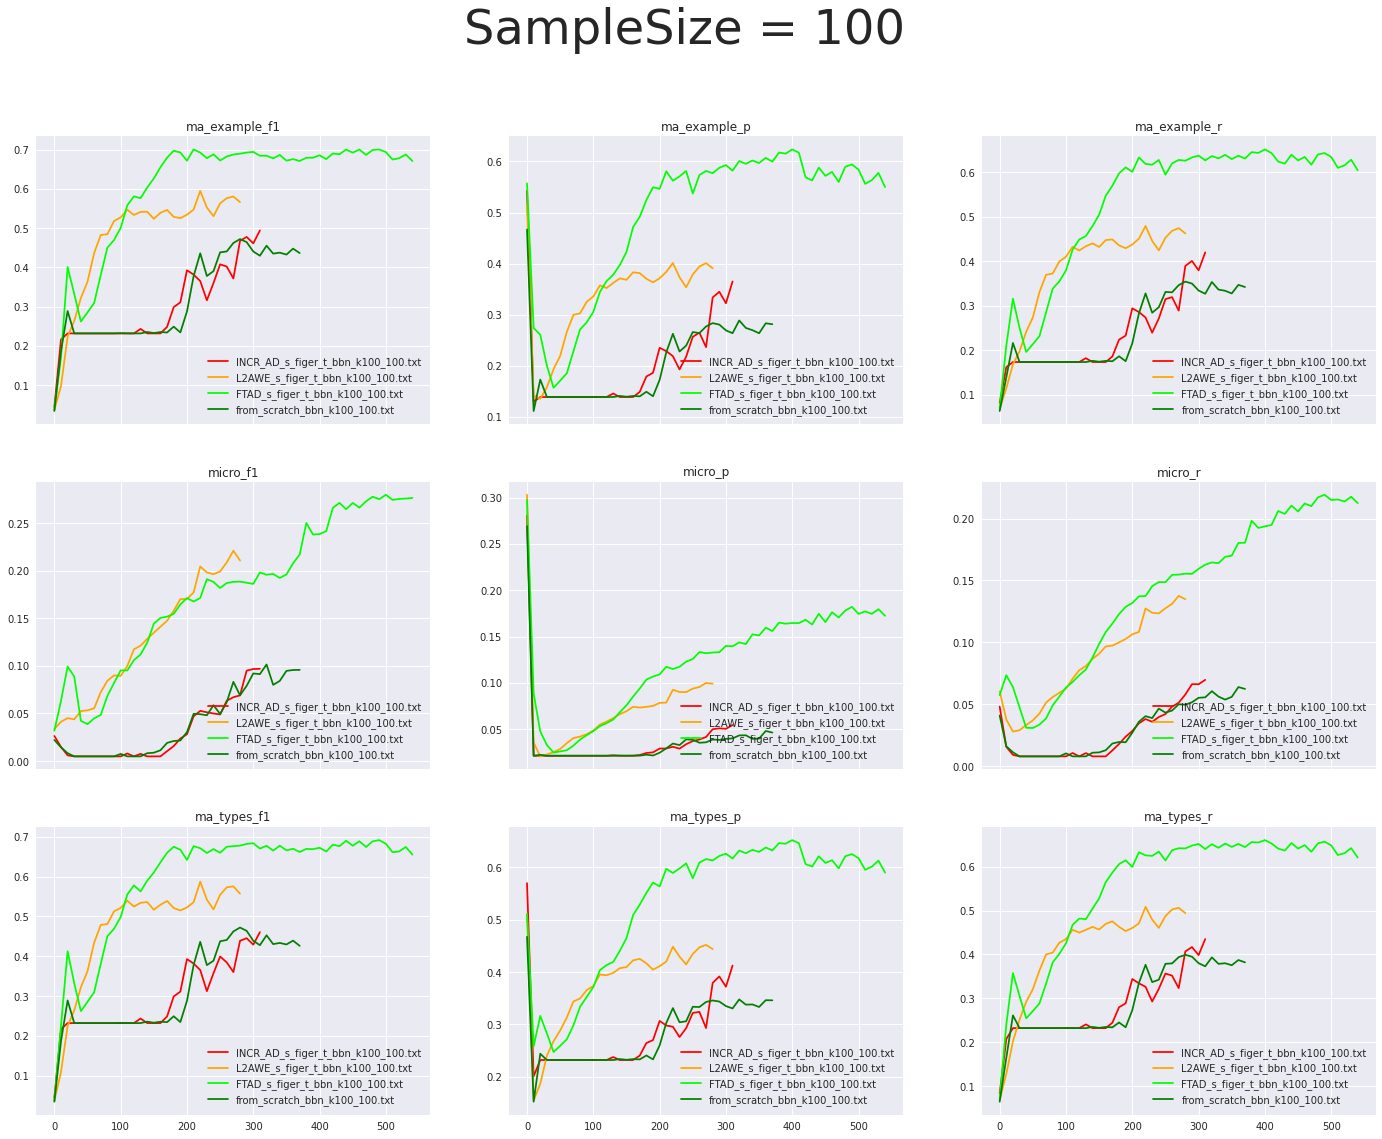

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True,
                                    figsize=(24, 18))

fig.suptitle('SampleSize = {}'.format(size), fontsize = 48)

for i, (e, v) in enumerate(epoch_dicts.items()):
    
    line_color = rainbow_colors_lines[i]
    e_color = rainbow_colors_errors[i]
        
    add_errors_to_all_subplots(v, e, line_color, e_color, err = False)

for ax in axs:
    for a in ax:
        a.legend(loc='lower right')